In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import urllib.request
from sklearn.model_selection import train_test_split

# Tensorflow
import tensorflow as tf
from tensorflow.keras import layers

# RETVec
from retvec.tf import RETVecTokenizer

# Datasets Folder
datasets_folder = Path("./datasets/goemotions")

# silence TF INFO messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  

# model save path
save_path = './models/emo_model'


## Get the Emotion Classes

In [7]:
classes = urllib.request.urlopen('https://raw.githubusercontent.com/google-research/google-research'
'/master/goemotions/data/emotions.txt').read().decode('utf8').split('\n')
num_classes = len(classes)
print(f"Number of Classes: {num_classes}")
print(classes)

Number of Classes: 28
['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


## Load the Dataset

In [3]:
goemotions_1 = pd.read_csv(datasets_folder / "goemotions_1.csv")
goemotions_2 = pd.read_csv(datasets_folder / "goemotions_2.csv")
goemotions_3 = pd.read_csv(datasets_folder / "goemotions_3.csv")
print("GoEmotions 1: ", goemotions_1.shape)
print("GoEmotions 2: ", goemotions_2.shape)
print("GoEmotions 3: ", goemotions_3.shape)

# Concatenate all of the datasets
goemotions = pd.concat([goemotions_1, goemotions_2, goemotions_3])
print("- - - - - - - - - - - - - - - - - - -\nGoEmotions Concatenated: ", goemotions.shape)

GoEmotions 1:  (70000, 37)
GoEmotions 2:  (70000, 37)
GoEmotions 3:  (71225, 37)
- - - - - - - - - - - - - - - - - - -
GoEmotions Concatenated:  (211225, 37)


In [4]:
goemotions.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


## Preparing Train/Test data and Conversion to Tensors

In [5]:
text = goemotions['text']
labels = goemotions[classes]

text_train, text_test, labels_train, labels_test = train_test_split(
    text, labels, test_size=0.20, random_state=23
)

In [6]:
# Train Data
x_train = tf.constant(text_train.tolist(), dtype=tf.string)
y_train = labels_train.values.astype(float)

# Test Data
x_test = tf.constant(text_test.tolist(), dtype=tf.string)
y_test = labels_test.values.astype(float)

In [7]:
print("x_train contents:")
print(x_train)
print(type(x_train))
print("\ny_train contents:")
print(y_train)
print(type(y_train))

x_train contents:
tf.Tensor(
[b'Agree, I love her so much'
 b"Peaky Blinders is the shit. I don't understand how there isn't more hype around this show."
 b'Thank you anyway! I\xe2\x80\x99m 30 and I don\xe2\x80\x99t get a lot of these things.'
 ... b'We gotta keep [NAME]'
 b'Man, I wish I liked music that much. Well maybe not *that* much, but you know what I mean. '
 b'Death will come in the end. Live while you can. Life is a once in an eternity opportunity.'], shape=(168980,), dtype=string)
<class 'tensorflow.python.framework.ops.EagerTensor'>

y_train contents:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
<class 'numpy.ndarray'>


## Creating the Keras Model
A key benefit of using RETVec is that inputs to RETVec and the text model are raw strings with no pre-processing neccessary, which greatly simplifies the training and inference process, especially for on-device models.

Notes:

- Using strings directly as input requires to use a shape of (1,) and specify the type tf.string
- We are using RETVecTokenizer() in its default configuration which is to truncate at 128 words and use a small pre-trained word embedding model to embed the words. You can experiment with shorter or longer length by changing the sequence_length parameter. The word embedding model offers significant improvements in adversarial and typo robustness. To use the RETVec character tokenizer only, set model=None.
- To use native TF ops only for TF Lite compatibility, set use_tf_lite_compatible_ops=True. see the TF Lite notebook for more details on how to convert a RETVec-based model to a TF Lite model which can run on-device.

In [70]:
# Inputs: Using strings directly requires to put a shape of (1,) and dtype tf.string
inputs = layers.Input(shape=(1, ), name="token", dtype=tf.string)

# Layers: add RETVec tokenizer layer with default settings
x = RETVecTokenizer(model='retvec-v1')(inputs)
# standard two layer LSTM
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

# Outputs: Dense layer with Sigmoid 
# Sigmoid is a better activation function for binary-class problems
# In our case, the data using one-hot encoding
outputs = layers.Dense(num_classes, activation='sigmoid')(x)

# Finish setting up the model
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token (InputLayer)          [(None, 1)]               0         
                                                                 
 ret_vec_tokenizer_1 (RETVe  (None, 128, 256)          230144    
 cTokenizer)                                                     
                                                                 
 bidirectional_2 (Bidirecti  (None, 128, 128)          164352    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 28)                3612      
                                                           

In [71]:
# Compile and Train the Model
batch_size = 256
epochs = 25
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(x_test, y_test))

Epoch 1/25
661/661 [==============================] - 1445s 2s/step - loss: 0.1586 - acc: 0.2740 - val_loss: 0.1478 - val_acc: 0.2995
Epoch 2/25
661/661 [==============================] - 1358s 2s/step - loss: 0.1428 - acc: 0.3200 - val_loss: 0.1373 - val_acc: 0.3426
Epoch 3/25
661/661 [==============================] - 1566s 2s/step - loss: 0.1355 - acc: 0.3488 - val_loss: 0.1325 - val_acc: 0.3592
Epoch 4/25
661/661 [==============================] - 1539s 2s/step - loss: 0.1313 - acc: 0.3615 - val_loss: 0.1292 - val_acc: 0.3668
Epoch 5/25
661/661 [==============================] - 1321s 2s/step - loss: 0.1284 - acc: 0.3719 - val_loss: 0.1265 - val_acc: 0.3778
Epoch 6/25
661/661 [==============================] - 1315s 2s/step - loss: 0.1262 - acc: 0.3805 - val_loss: 0.1246 - val_acc: 0.3872
Epoch 7/25
661/661 [==============================] - 1163s 2s/step - loss: 0.1243 - acc: 0.3864 - val_loss: 0.1237 - val_acc: 0.3872
Epoch 8/25
661/661 [==============================] - 1023s 2s

## Plot the Training Accuracy and Validation Accuracy

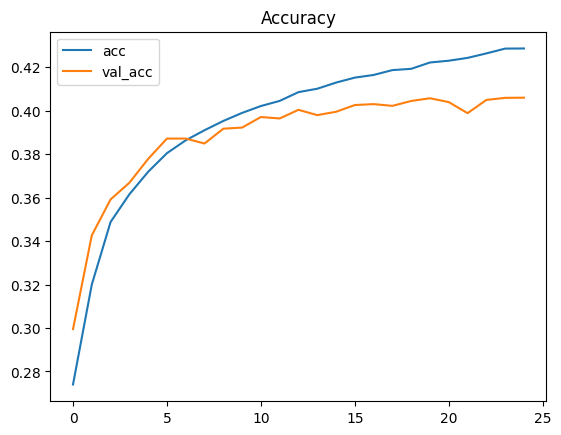

In [72]:
# Visualize the Training Curves
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.title(f'Accuracy')
plt.show()

## Save the Model

In [73]:
# Saving the Model
model.save(save_path)

INFO:tensorflow:Assets written to: ./models/emo_model\assets


INFO:tensorflow:Assets written to: ./models/emo_model\assets


## Load the Model
#### To load the model, run everything <b>EXCEPT</b> for:
- Creating the Keras Model Section
- Plotting Section
- Saving the Model Section

In [3]:
model = tf.keras.models.load_model(save_path, compile=True)

In [10]:
loss, accuracy = model.evaluate(x_test, y_test)

print(f'Loss: {loss * 100:.2f}%')
print(f'Accuracy: {accuracy * 100:.2f}%')

1321/1321 [==============================] - 89s 64ms/step - loss: 0.1185 - acc: 0.4060
Loss: 11.85%
Accuracy: 40.60%


In [4]:
# The model returns the array of probabilities for all 28 emotions
model(tf.constant(["I feel so bad"]))[0]

<tf.Tensor: shape=(28,), dtype=float32, numpy=
array([9.3747186e-04, 1.7227542e-03, 1.3423254e-02, 3.5864666e-02,
       1.2334862e-02, 2.4428999e-02, 3.8406607e-03, 4.2158054e-04,
       1.5222796e-03, 3.2064754e-01, 7.0128568e-02, 9.6721083e-02,
       5.2906834e-02, 1.0024547e-03, 8.4288567e-03, 8.4581220e-04,
       3.6273327e-02, 1.0457520e-03, 1.5308937e-03, 1.8504879e-02,
       5.3336443e-03, 1.1322194e-03, 2.3114558e-02, 1.3336779e-03,
       5.9525438e-02, 5.1732826e-01, 1.1333829e-03, 1.1588553e-01],
      dtype=float32)>

In [8]:
def predict_emotions(txt):
    predictions = model(tf.constant([txt]))[0]
    best_prediction_index = tf.argmax(predictions).numpy()
    predicted_emotion = classes[best_prediction_index]
    probability = round(tf.reduce_max(predictions).numpy() * 100, 1)
    print(f"Emotion: {predicted_emotion} ({probability})%")

In [15]:
txts = [
    "he is really good at what he is doing",
    "I am angry",
    "I find these very funny",
    "I enjoy having a good icecream.",
    "I don't like this. Take it away",
    "You shocked me!",
    "That was embarassing.",
    "I think that you are right",
    "The food tastes so disgusting",
    "I am very sorry for your loss",
    "I just realized that I should be working right now",
    "I think I really like you",
    "This place is creepy and scary",
    "I want to be a billionaire",
    "I just feel so annoyed"
]
for txt in txts:
    print(f"- - - - | {txt} | - - - -")
    predict_emotions(txt)

- - - - | he is really good at what he is doing | - - - -
Emotion: admiration (81.8)%
- - - - | I am angry | - - - -
Emotion: anger (58.6)%
- - - - | I find these very funny | - - - -
Emotion: amusement (65.7)%
- - - - | I enjoy having a good icecream. | - - - -
Emotion: joy (74.8)%
- - - - | I don't like this. Take it away | - - - -
Emotion: disapproval (64.3)%
- - - - | You shocked me! | - - - -
Emotion: surprise (44.8)%
- - - - | That was embarassing. | - - - -
Emotion: embarrassment (51.1)%
- - - - | I think that you are right | - - - -
Emotion: approval (59.3)%
- - - - | The food tastes so disgusting | - - - -
Emotion: disgust (87.2)%
- - - - | I am very sorry for your loss | - - - -
Emotion: sadness (63.9)%
- - - - | I just realized that I should be working right now | - - - -
Emotion: realization (77.6)%
- - - - | I think I really like you | - - - -
Emotion: love (52.6)%
- - - - | This place is creepy and scary | - - - -
Emotion: fear (95.7)%
- - - - | I want to be a billionaire

In [16]:
# the model works even with typos, substitutions, and emojis!
txt = "I enjoy hving a g00d ic3cream!!! 🍦"
predict_emotions(txt)

Emotion: joy (60.8)%
